In [23]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon

In [2]:
file = "/Users/delmoral/data/ams2025/titan/ascii/Tracks2Ascii.derecho.txt"

Open text file and adjust columns names in order to import to a pandas dataframe. 
Since the text file has irregular delimiters, we need to add some extra steps.

In [3]:
#open file and extract column names
f = open(file)
lines = f.readlines()
f.close()

label_line_index = None  

for i, line in enumerate(lines):
    if 'labels' in line:
        label_line_index = i
        break  
labels = lines[label_line_index].split(":", 1)[1].strip().split(",")

In [4]:
#the data lines are the ones that do not start with #
data_lines = [line.strip() for line in lines if not line.startswith("#")]

The file last three rows are labeled "parents","children","nPolySidesPolygonRays*72". Parents and children columns refer to identifiers based on merging and splitting processes. The Polygon column shows the values for the lines from the polygon centroid to each vertex, in km. There are 72 values because each line is separated 5 deg (72*5 =360). With that information and the "envelope_centroid" column, we can retrieve the cells envelopes at each timestep.

In [5]:
rows = []
for line in data_lines:
    parts = line.split()

    try:
        # Try parsing the polygon count value (always right before 72 values)
        poly_count_index = -73  # 72 floats + 1 count (the column starts with the numnber 72, which is not part of the values)

        # Parents and children may be missing
        parent_str = parts[poly_count_index - 2]
        child_str = parts[poly_count_index - 1]

        # Handle missing values marked as "-"
        parents = int(parent_str) if parent_str != '-' else np.nan
        children = int(child_str) if child_str != '-' else np.nan

        # Polygon values: skip the count, get the next 72 values
        polygon_values = list(map(float, parts[poly_count_index + 1:]))

        # Fixed columns
        fixed_cols = parts[:poly_count_index - 2]

        # Combine into one row
        row = fixed_cols + [parents, children, polygon_values]
        rows.append(row)
    except Exception as e:
        continue

In [8]:
# Final columns: fixed + 3 custom ones
final_labels = labels[:len(rows[0]) - 3] + ['parents', 'children', 'nPolySidesPolygonRays']

# Create DataFrame
df = pd.DataFrame(rows, columns=final_labels)

# Convert date and time columns to datetime
df['date_utc'] = pd.to_datetime(
    df['Year'].astype(str) + '-' +
    df['Month'].astype(str).str.zfill(2) + '-' +
    df['Day'].astype(str).str.zfill(2) + ' ' +
    df['Hour'].astype(str).str.zfill(2) + ':' +
    df['Min'].astype(str).str.zfill(2) + ':' +
    df['Sec'].astype(str).str.zfill(2),
    format='%Y-%m-%d %H:%M:%S',
    utc=True
)
# Print df 
print(df)

    NSimpleTracks ComplexNum SimpleNum  Year Month Day Hour Min Sec  \
0             118          0         0  2022    05  21   14  59  49   
1             118          0         1  2022    05  21   14  59  49   
2             118          0         1  2022    05  21   15  05  50   
3             118          0         2  2022    05  21   14  59  49   
4             118          0         3  2022    05  21   14  59  49   
..            ...        ...       ...   ...   ...  ..  ...  ..  ..   
178             1        172       172  2022    05  21   18  29  49   
179             1        172       172  2022    05  21   18  35  48   
180             1        172       172  2022    05  21   18  41  49   
181             1        172       172  2022    05  21   18  47  48   
182             1        172       172  2022    05  21   18  53  49   

    dBZThreshold  ... HailFOKRCat0-4 HailWaldvogelProb HailMassAloft(ktons)  \
0             35  ...              4                 1              

Let's explore some TITAN outputs now!

TITAN identifies individual radar cells  within every radar volume , based on reflectivity and volume thresholds. Then, it tracks them through time using a combination and optimization scheme, and geometric logic to address splitting and merging storms. In this example, we have set the minimum reflectivity threshold to 35 dBZ. This is shown in column 'dBZThreshold'. That threshold defines the minimum reflectivity for our 'cell' entity.

TITAN outputs cell fetures at each tracking timestep, and identifies cells within major systems, based on their interaction with neighboring cells. Therefore, each cell will have a simple and a complex identifier (“SimpleNum” and “ComplexNum”) in the TITAN output text file. For example, if we are tracking a multicell system, all the individual cells tracked within the major system will have different "SimplNum" identifiers, however, they will al have the same "ComplexNum" identifier (the main multicell system).

Let's inspect our derecho case now! How many Complexes we can identify? Which one contains more tracks (e.g., single cell tracks, and split/merge processes)?

/var/folders/bl/b2x9bfwn45x__3wnk9pmm8840000gp/T/ipykernel_62260/1341863022.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='ComplexNum', x='NumSimple', data=simple_counts, palette='Set3')


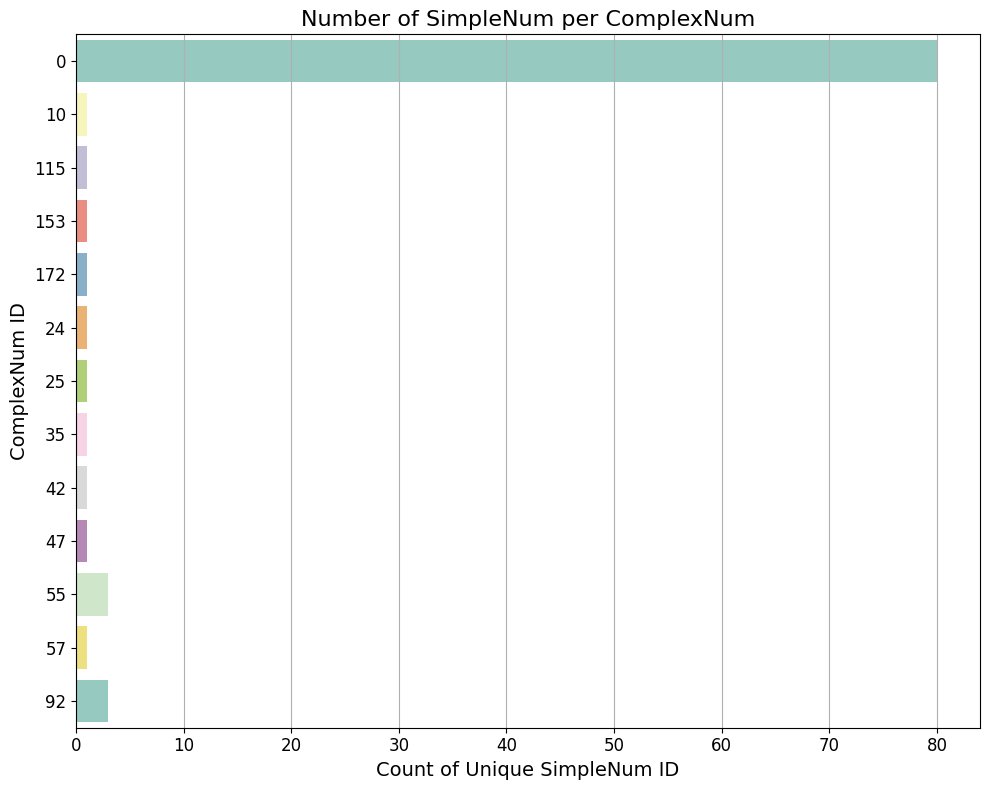

In [10]:
# Count number of unique SimpleNum per ComplexNum
simple_counts = df.groupby('ComplexNum')['SimpleNum'].nunique().reset_index(name='NumSimple')

# Sort (optional, for better visuals)
#simple_counts = simple_counts.sort_values(by='NumSimple', ascending=False)

# Plot 1
plt.figure(figsize=(10, 8))
sns.barplot(y='ComplexNum', x='NumSimple', data=simple_counts, palette='Set3')
plt.title('Number of SimpleNum per ComplexNum', fontsize=16)
plt.xlabel('Count of Unique SimpleNum ID', fontsize=14)
plt.ylabel('ComplexNum ID', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='x')
plt.show()


Now we see that ComplexNum with ID=0 is the one that contains the majority of the cells. Let's do some further analysis.
We will plot now the xaximum reflectivity (MaxDBZ(dBZ) in the TITAN file) as a timeseries, and we will identify the different cells (SimpleNum) within the major system (ComplexNum) in different colors.

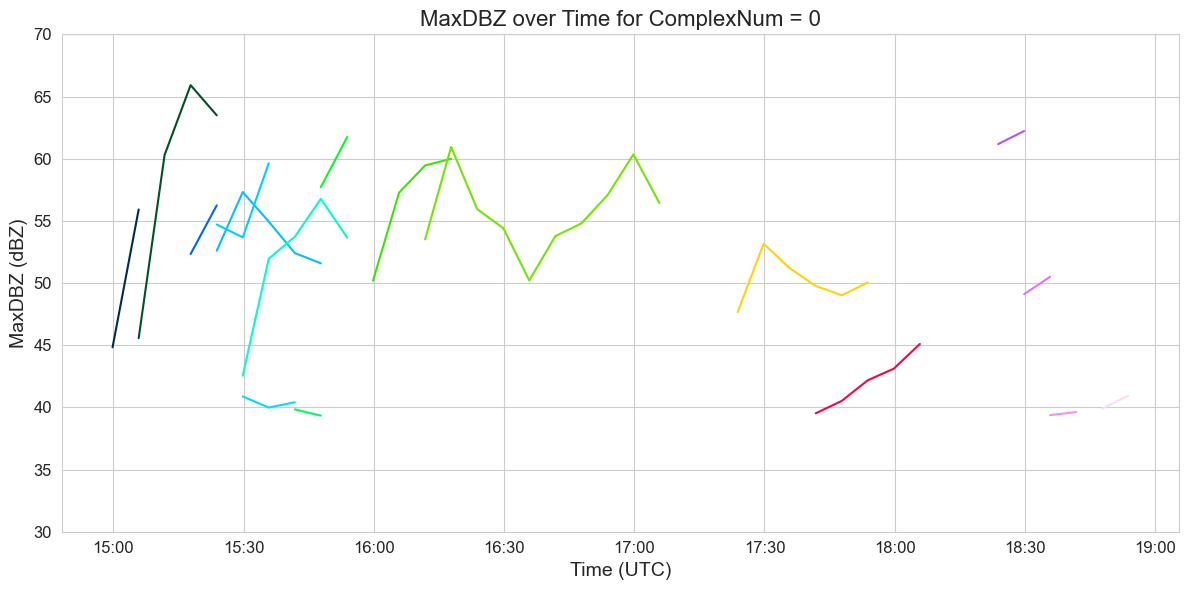

In [29]:
#  Filter dataframe for ComplexNum == 0 and sort by time
df0 = df[df['ComplexNum'] == "0"].copy()
df0 = df0.sort_values('date_utc')
df0['MaxDBZ(dBZ)'] = pd.to_numeric(df0['MaxDBZ(dBZ)'], errors='coerce')
df0['date_utc'] = pd.to_datetime(df0['date_utc'], errors='coerce', utc=True)

#  Plot
y_min = 30
y_max = 70
y_ticks = np.arange(y_min, y_max + 1, 5)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(data=df0, x='date_utc', y='MaxDBZ(dBZ)', hue='SimpleNum', palette='gist_ncar')
plt.ylim(y_min, y_max)
plt.yticks(y_ticks,fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(fontsize=12)
plt.title('MaxDBZ over Time for ComplexNum = 0', fontsize=16)
plt.xlabel('Time (UTC)', fontsize=14)
plt.ylabel('MaxDBZ (dBZ)',fontsize=14)
# Remove legend
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()


Now we can also plot the centroids of each tracked cell, in a Cartopy map, and add circles around the centroid based on how big the cell volume is in each timestep. We will also show the different cells ('SimpleNum') in different colors.

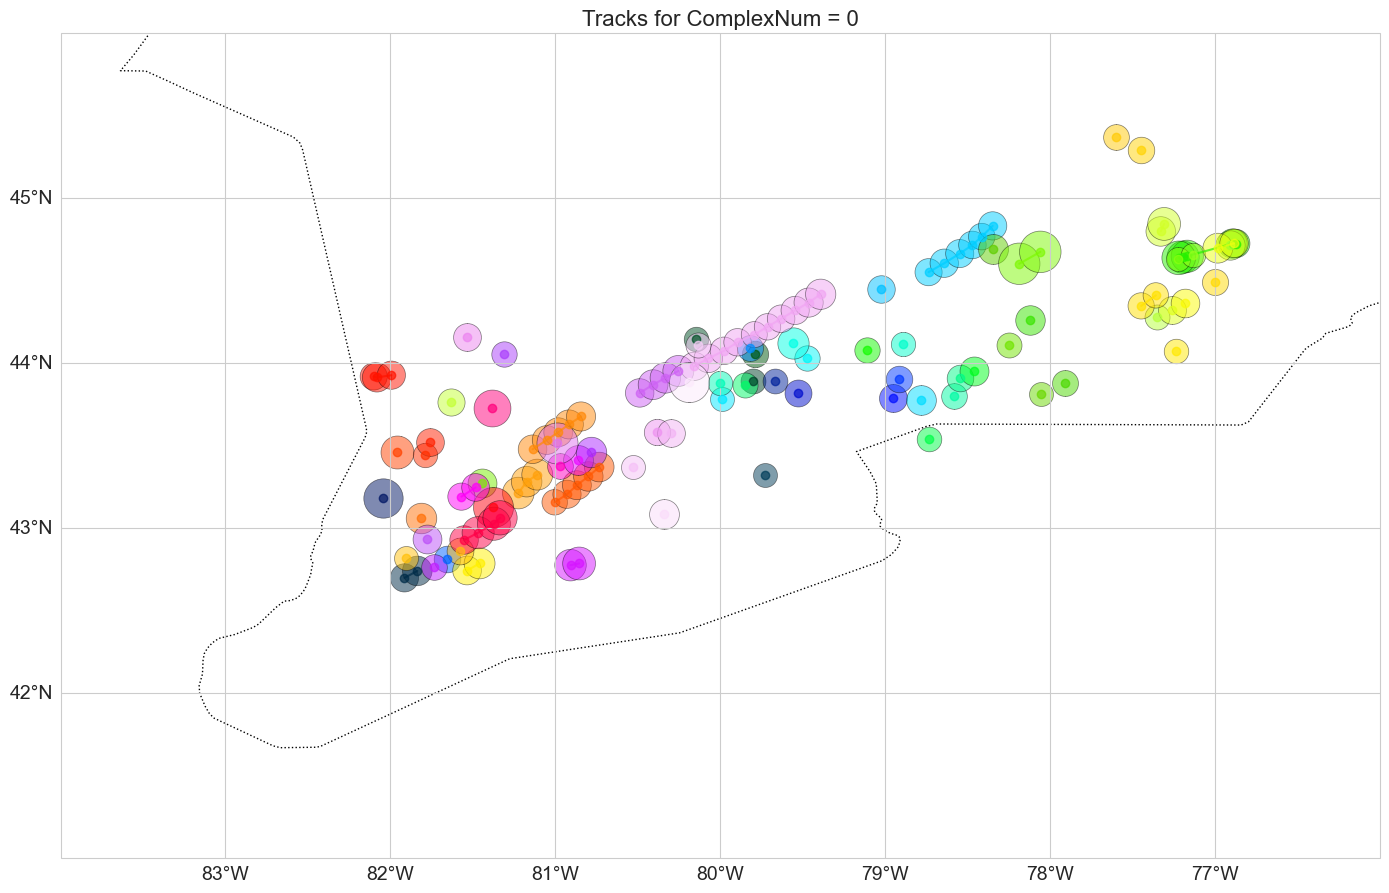

In [34]:
df0 = df0.sort_values(['SimpleNum', 'date_utc'])
# Convert lat/lon columns to numeric, coercing errors to NaN
df0['VolCentroidLat(deg)'] = pd.to_numeric(df0['VolCentroidLat(deg)'], errors='coerce')
df0['VolCentroidLon(deg)'] = pd.to_numeric(df0['VolCentroidLon(deg)'], errors='coerce')

# Set up map plot
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-84, -76, 41, 46], crs=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

# Unique SimpleNum and colors
simple_nums = df0['SimpleNum'].unique()
palette = sns.color_palette("gist_ncar", n_colors=len(simple_nums))
df0['Volume(km3)'] = pd.to_numeric(df0['Volume(km3)'], errors='coerce').fillna(0)

# We normalize the Volume for the marker sizes
for i, simple_num in enumerate(simple_nums):
    track = df0[df0['SimpleNum'] == simple_num].copy()

    lat = track['VolCentroidLat(deg)']
    lon = track['VolCentroidLon(deg)']
    vol = pd.to_numeric(track['Volume(km3)'], errors='coerce').fillna(0)

    # Scale volume: use log scale to compress range + clip to reasonable range
    sizes = np.log10(vol + 1) * 200  # +1 to avoid log(0)
    #sizes = sizes.clip(10, 300)      

    ax.plot(lon, lat, marker='o', linestyle='-', color=palette[i], alpha=0.7, transform=ccrs.PlateCarree())
    ax.scatter(lon, lat, s=sizes, color=palette[i], alpha=0.5, transform=ccrs.PlateCarree(), edgecolor='k', linewidth=0.5)

#plt.legend(title='SimpleNum', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Tracks for ComplexNum = 0', fontsize= 16)
plt.tight_layout()
plt.show()


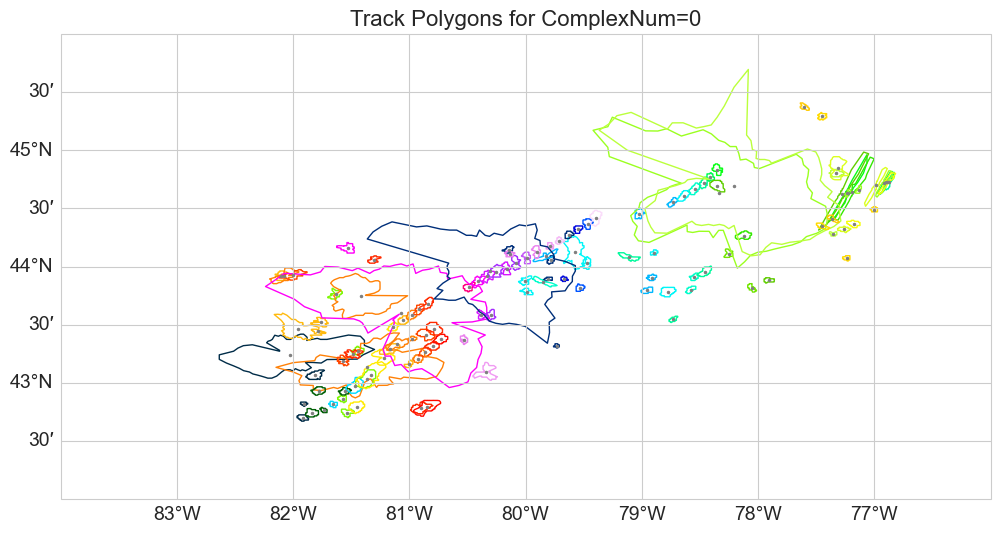

In [46]:
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the map extent (lon_min, lon_max, lat_min, lat_max)
ax.set_extent([-84, -76, 42, 46], crs=ccrs.PlateCarree())
ax.coastlines()

#color by time
timesteps = df0['date_utc'].unique()
palette = sns.color_palette("gist_ncar", n_colors=len(timesteps))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

for idx, row in df0.iterrows():
    lat_centroid = float(row['EnvelopeCentroidLat(deg)'])
    lon_centroid = float(row['EnvelopeCentroidLon(deg)'])
    rays = row['nPolySidesPolygonRays']
    
    if not rays or len(rays) == 0:
        continue  
    
    angles = np.deg2rad(np.arange(0, 360, 5))  # 72 vertices at every 5 degrees
    rays = np.array(rays, dtype=float) #from centroid to vertex
    
    # Rays in km to degrees
    ray_x = rays * np.cos(angles)
    ray_y = rays * np.sin(angles)

    # Approximate conversion from km to degrees lat/lon
    lat_vertices = lat_centroid + ray_y / 111
    lon_vertices = lon_centroid + ray_x / (111 * np.cos(np.deg2rad(lat_centroid)))

    polygon_points = list(zip(lon_vertices, lat_vertices))
    
    poly = Polygon(polygon_points)
    time_idx = np.where(timesteps == row['date_utc'])[0][0]

    ax.add_geometries([poly], crs=ccrs.PlateCarree(),
                      edgecolor=palette[time_idx], facecolor='none', linewidth=1)
    
    ax.plot(lon_centroid, lat_centroid, marker='o',color='grey', markersize=1.5, transform=ccrs.PlateCarree())



plt.title("Track Polygons for ComplexNum=0", fontsize=16)
plt.show()
